In [ ]:
!pip install peartree
!pip install osmnx
!pip install ripser
!pip install persim
!pip install folium

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import peartree as pt
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import numpy as np
import os
import pandas as pd
import csv
from ripser import ripser
from persim import plot_diagrams
import math
import requests
import time
import folium
from IPython.display import display
%matplotlib inline

In [5]:
path = '/content/drive/MyDrive/GTFS/Local_Transit'

In [6]:
def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    radius = 6371.0  # Earth's radius in kilometers

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

def create_transit_graph(path, lat_range, lon_range):

    # Initialize the graph
    transit_graph = nx.DiGraph()

    #Create dictionaries to store stop, parent and trip information
    stop_dict = {}
    parent_station_dict = {}
    trip_to_previous_stop = {}

    # Load stops.txt to populate the dictionaries
    stops_file = open(path + '/stops.txt', 'r', encoding='utf-8-sig')
    stops_reader = csv.reader(stops_file)
    next(stops_reader)  # Skip the header row

    for stop in stops_reader:
        stop_id = stop[2]
        latitude = float(stop[3])
        longitude = float(stop[4])

        if lat_range[0] <= latitude <= lat_range[1] and lon_range[0] <= longitude <= lon_range[1]:
            stop_name = stop[0]
            stop_dict[stop_id] = (stop_name, latitude, longitude)
            parent_station = stop[1]
            if parent_station:
                parent_station_dict[stop_id] = parent_station

    # Load stop_times.txt to create nodes and edges in the transit graph
    stop_times_file = open(path + '/stop_times.txt', 'r', encoding='utf-8-sig')
    stop_times_reader = csv.reader(stop_times_file)
    next(stop_times_reader)  # Skip the header row

    for stop_time in stop_times_reader:
        trip_id = stop_time[0]
        stop_id = stop_time[3]

        # Connect stops based on the same trip
        if stop_id in stop_dict:
            transit_graph.add_node(stop_id)

            previous_stop_id = trip_to_previous_stop.get(trip_id)
            if previous_stop_id:
                edge_weight = haversine_distance(
                    (stop_dict[previous_stop_id][1], stop_dict[previous_stop_id][2]),
                    (stop_dict[stop_id][1], stop_dict[stop_id][2])
                )
                transit_graph.add_edge(previous_stop_id, stop_id, weight=edge_weight)
            trip_to_previous_stop[trip_id] = stop_id

            parent_station = parent_station_dict.get(stop_id)
            if parent_station and parent_station in stop_dict:
                edge_weight = haversine_distance(
                    (stop_dict[parent_station][1], stop_dict[parent_station][2]),
                    (stop_dict[stop_id][1], stop_dict[stop_id][2])
                )
                transit_graph.add_edge(parent_station, stop_id, weight=edge_weight)

    # Close the GTFS files
    stops_file.close()
    stop_times_file.close()

    print(f"Number of Nodes: {transit_graph.number_of_nodes()}")
    print(f"Number of Edges: {transit_graph.number_of_edges()}")
    print("-----------------------------------------------------")

    return transit_graph, stop_dict


Verification of networks using Folium

In [10]:
def plot_transit_graph_on_map(transit_graph, stop_dict, city_name, path):
    """Plot the transit graph on a map and display it."""

    #Calculation of average latitude and longitude of city networks to verify for correctness and to center the folium map around the average lat, lon
    avg_lat = sum([coords[1] for coords in stop_dict.values()]) / len(stop_dict)
    avg_lon = sum([coords[2] for coords in stop_dict.values()]) / len(stop_dict)
    print(avg_lat,avg_lon)
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)

    #Adding nodes (stops) to the folium map
    for stop_id, (stop_name, lat, lon) in stop_dict.items():
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=1,
            tooltip=stop_name
        ).add_to(m)

    #Adding edges (routes) to the folium map
    for edge in transit_graph.edges():
        coord1 = stop_dict[edge[0]][1], stop_dict[edge[0]][2]
        coord2 = stop_dict[edge[1]][1], stop_dict[edge[1]][2]
        folium.PolyLine([coord1, coord2], color="blue").add_to(m)

    # Save the map to an HTML file
    filename = os.path.join(path, f"{city_name}_transit_map.html")
    m.save(filename)
    print(f"Saved map for {city_name} to {filename}")

    return m

In [ ]:
city_lat_lon_ranges = {
    'Aachen': ((50.7, 50.8), (6.0, 6.2)),
    'Berlin': ((52.3, 52.7), (13.2, 13.6)),
    'Frankfurt': ((50.0, 50.2), (8.6, 9.0)),
    'Hamburg': ((53.4, 53.7), (9.8, 10.2)),
    'Leipzig': ((51.2, 51.5), (12.2, 12.7)),
    'Munich': ((48.0610, 48.2480), (11.3600, 11.7220)),
    'Cologne': ((50.8300, 51.0500), (6.7900, 7.1100)),
    'Stuttgart': ((48.6900, 48.8600), (9.1200, 9.3100)),
    'Dortmund': ((51.4200, 51.6000), (7.3400, 7.6500)),
    'Duesseldorf': ((51.1500, 51.3100), (6.6500, 6.9800))
}


#Plot the networks and the respective persistence diagrams
for city_name, (lat_range, lon_range) in city_lat_lon_ranges.items():
    transit_graph, stops = create_transit_graph(path, lat_range, lon_range)
    plot_transit_graph_on_map(transit_graph, stops, city_name, path)

    '''
    print(f"Map for {city_name}")
    m.save(f"{city_name}_map.html")  # Saves the map as an HTML file
    display(m)
    '''

Number of Nodes: 1356
Number of Edges: 2309
-----------------------------------------------------
50.76149288798823 6.1080684362564455
Saved map for Aachen to /content/drive/MyDrive/GTFS/Local_Transit/Aachen_transit_map.html
Number of Nodes: 10059
Number of Edges: 16341
-----------------------------------------------------
52.50093074254479 13.398532347017927
Saved map for Berlin to /content/drive/MyDrive/GTFS/Local_Transit/Berlin_transit_map.html
Number of Nodes: 4548
Number of Edges: 7374
-----------------------------------------------------
50.10994926027692 8.762096200483587
Saved map for Frankfurt to /content/drive/MyDrive/GTFS/Local_Transit/Frankfurt_transit_map.html
Number of Nodes: 6924
Number of Edges: 10524
-----------------------------------------------------
53.557375040866404 10.011674993357378
Saved map for Hamburg to /content/drive/MyDrive/GTFS/Local_Transit/Hamburg_transit_map.html
Number of Nodes: 3634
Number of Edges: 5929
---------------------------------------------

Euler curves

In [7]:
def euler_char(graph):
    return graph.number_of_nodes() - graph.number_of_edges()

def filtration_by_edge_weight(graph, steps=100):
    edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)

    thresholds = np.linspace(min_weight, max_weight, steps)
    euler_chars = []

    for threshold in thresholds:
        subgraph_edges = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] <= threshold]
        subgraph = nx.Graph()
        subgraph.add_edges_from(subgraph_edges)
        euler_chars.append(euler_char(subgraph))

    return thresholds, euler_chars

Number of Nodes: 1356
Number of Edges: 2309
-----------------------------------------------------
Number of Nodes: 10059
Number of Edges: 16341
-----------------------------------------------------
Number of Nodes: 4548
Number of Edges: 7374
-----------------------------------------------------
Number of Nodes: 6924
Number of Edges: 10524
-----------------------------------------------------
Number of Nodes: 3634
Number of Edges: 5929
-----------------------------------------------------
Number of Nodes: 5240
Number of Edges: 8473
-----------------------------------------------------
Number of Nodes: 4212
Number of Edges: 6487
-----------------------------------------------------
Number of Nodes: 1842
Number of Edges: 2930
-----------------------------------------------------
Number of Nodes: 4199
Number of Edges: 7063
-----------------------------------------------------
Number of Nodes: 3841
Number of Edges: 6356
-----------------------------------------------------


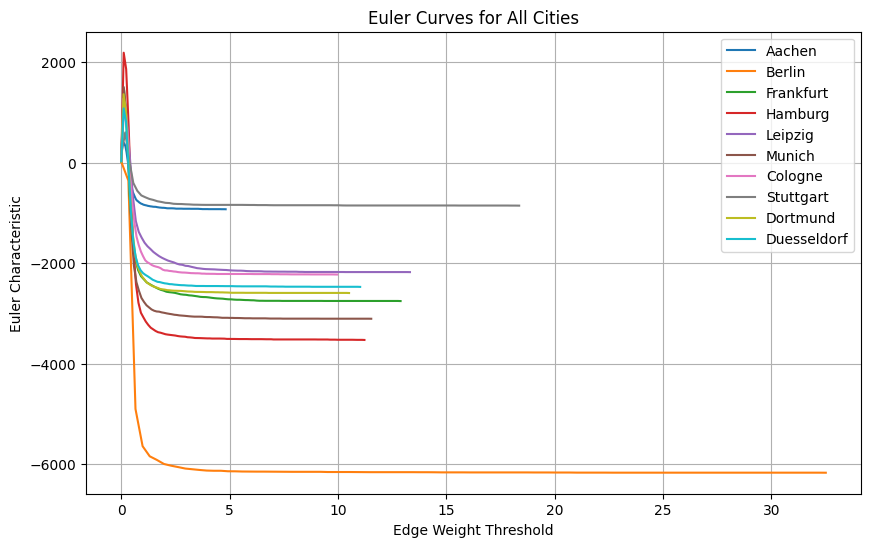

In [9]:
city_lat_lon_ranges = {
    'Aachen': ((50.7, 50.8), (6.0, 6.2)),
    'Berlin': ((52.3, 52.7), (13.2, 13.6)),
    'Frankfurt': ((50.0, 50.2), (8.6, 9.0)),
    'Hamburg': ((53.4, 53.7), (9.8, 10.2)),
    'Leipzig': ((51.2, 51.5), (12.2, 12.7)),
    'Munich': ((48.0610, 48.2480), (11.3600, 11.7220)),
    'Cologne': ((50.8300, 51.0500), (6.7900, 7.1100)),
    'Stuttgart': ((48.6900, 48.8600), (9.1200, 9.3100)),
    'Dortmund': ((51.4200, 51.6000), (7.3400, 7.6500)),
    'Duesseldorf': ((51.1500, 51.3100), (6.6500, 6.9800))
}

#Initialize plot dimensions
plt.figure(figsize=(10, 6))

#Plot the networks and the respective persistence diagrams
for city_name, (lat_range, lon_range) in city_lat_lon_ranges.items():
    transit_graph, stops = create_transit_graph(path, lat_range, lon_range)

    thresholds, euler_chars = filtration_by_edge_weight(transit_graph)
    plt.plot(thresholds, euler_chars, label=city_name)

plt.xlabel('Edge Weight Threshold')
plt.ylabel('Euler Characteristic')
plt.title('Euler Curves for All Cities')
plt.legend()
plt.grid(True)
#plt.axis('equal')
#plt.tight_layout()

#Plot on the same coordinate system
plt.show()